In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
def load_MeTooMMD_data(path='MeTooMMD_train.csv'):
	return pd.read_csv(path)
MeTooMMD=load_MeTooMMD_data()

In [3]:
print(MeTooMMD.shape)

MeTooMMD.head()

(7978, 11)


,TweetId,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
0,1052237153789390853,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1052207832081129472,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1052183746344960000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1052156864840908800,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1052095305133510656,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [4]:
comments=pd.read_csv('Tweet_cmt.csv')
MeToo = MeTooMMD[MeTooMMD['TweetId'].isin(comments['Id'])]

In [5]:
MeToo_labels = MeToo[["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]]
MeToo_labels.shape

(6867, 10)

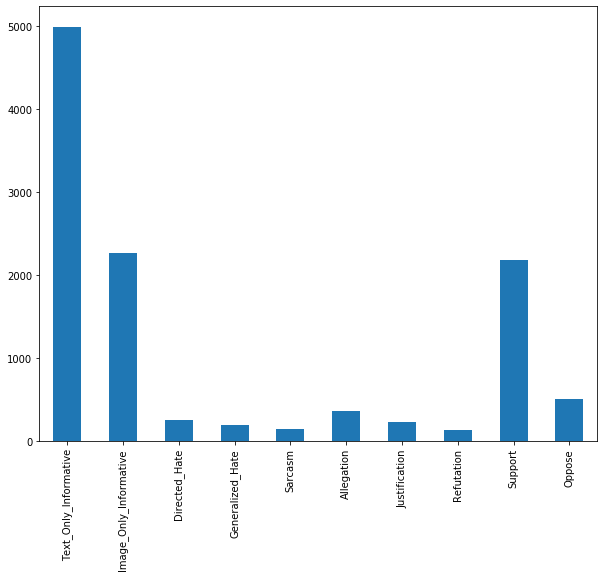

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

MeToo_labels.sum(axis=0).plot.bar()

In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
X = []
sentences = list(comments["Comments"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = MeToo_labels.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/media/mohsin/New Volume/Downloads/glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [12]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(150)(embedding_layer)
dense_layer_1 = Dense(10, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          7781700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1510      
Total params: 8,053,810
Trainable params: 272,110
Non-trainable params: 7,781,700
_________________________________________________________________
None


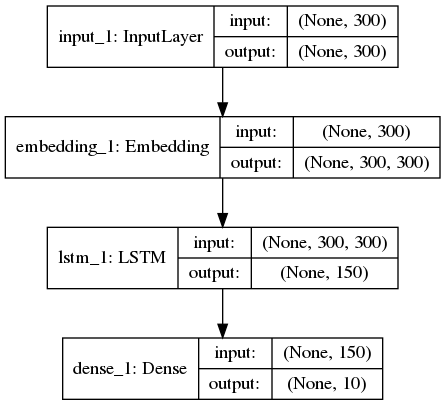

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=300, verbose=1, validation_split=0.2)

Train on 4394 samples, validate on 1099 samples
Epoch 1/300
4394/4394 [==============================] - 129s 29ms/step - loss: 0.3265 - acc: 0.8801 - val_loss: 0.2920 - val_acc: 0.8832
Epoch 2/300
4394/4394 [==============================] - 131s 30ms/step - loss: 0.2994 - acc: 0.8803 - val_loss: 0.2883 - val_acc: 0.8832
Epoch 3/300
  64/4394 [..............................] - ETA: 3:21 - loss: 0.2971 - acc: 0.8906

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
test_predictions = model.predict(X_test)

print(test_predictions)


In [ ]:
import pandas as pd 
prediction = model.predict(X_test)
df = pd.DataFrame(prediction, columns = [["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]])

In [ ]:
df.describe()

In [ ]:
df.head()